In [1]:
!pip install pysqlite3 --upgrade

Requirement already up-to-date: pysqlite3 in /Users/jamesfrancis/anaconda3/lib/python3.7/site-packages (0.2.1)


In [99]:
import sqlite3
import pandas as pd

sqlite_file = '/Users/jamesfrancis/Documents/Data Projects/Pitchfork/pf_database.sqlite'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

In [108]:
q = """SELECT artists.reviewid,artists.artist,title,score,genre,year,best_new_music FROM artists 
                    INNER JOIN genres ON artists.reviewid=genres.reviewid 
                    INNER JOIN years on artists.reviewid=years.reviewid 
                    INNER JOIN reviews ON artists.reviewid=reviews.reviewid"""
df = pd.read_sql_query(q, conn)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24424 entries, 0 to 24423
Data columns (total 7 columns):
reviewid          24424 non-null int64
artist            24424 non-null object
title             24424 non-null object
score             24424 non-null float64
genre             21944 non-null object
year              23881 non-null float64
best_new_music    24424 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [109]:
df.dropna(axis=0,how='any',inplace=True)
df.reset_index(inplace=True)
df.drop(labels=['index'],axis=1,inplace=True)
#df.info()
#df.describe()
df.head()

,reviewid,artist,title,score,genre,year,best_new_music
0,22703,massive attack,mezzanine,9.3,electronic,1998.0,0
1,22721,krallice,prelapsarian,7.9,metal,2016.0,0
2,22659,uranium club,all of them naturals,7.3,rock,2016.0,0
3,22661,kleenex,first songs,9.0,rock,2016.0,1
4,22661,liliput,first songs,9.0,rock,2016.0,1


              reviews
genre                
rock             9844
electronic       3996
experimental     2049
rap              1664
pop/r&b          1476
metal             920
folk/country      732
jazz              496
global            265


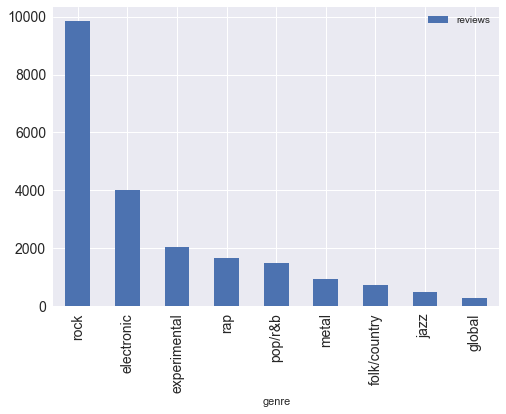

In [110]:
reviews_artist = df.groupby('artist').count().reset_index().rename(columns={'genre':'reviews'})[['artist','reviews']].set_index('artist').sort_values('reviews',ascending=False)
reviews_genre = df.groupby('genre').count().reset_index().rename(columns={'artist':'reviews'})[['genre','reviews']].set_index('genre').sort_values('reviews',ascending=False)
print(reviews_genre)
top_genres = reviews_genre.index[:5]

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
reviews_genre.plot(kind='bar',fontsize=14)
#reviews_artist[:10].plot(kind='bar',fontsize=14)

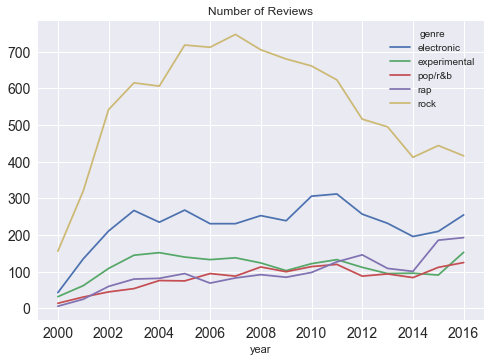

In [111]:
top_genres_boolean_mask = []
for i in range(len(df)):
    top_genres_boolean_mask.append(df['genre'][i] in top_genres)
reviews_year_genre = df[(df['year']>=2000) & (df['year']<2017) & top_genres_boolean_mask].groupby(['year','genre']).count().drop(labels='reviewid',axis=1).rename(columns={'artist':'reviews'}).sort_values(['year','reviews'],ascending=False)['reviews']
reviews_year_genre.unstack().plot(kind='line',fontsize=14,title="Number of Reviews")

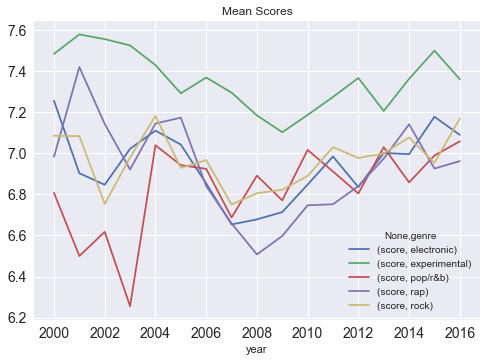

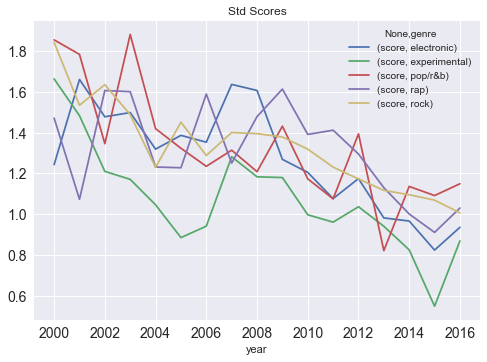

In [112]:
top_genres_boolean_mask = []
for i in range(len(df)):
    top_genres_boolean_mask.append(df['genre'][i] in top_genres)

reviews_score_mean = df[(df['year']>=2000) & (df['year']<2017) & top_genres_boolean_mask].groupby(['year','genre']).mean().drop(labels='reviewid',axis=1)[['score']].sort_values(['year','score'],ascending=False)
reviews_score_std = df[(df['year']>=2000) & (df['year']<2017) & top_genres_boolean_mask].groupby(['year','genre']).std().drop(labels='reviewid',axis=1)[['score']].sort_values(['year','score'],ascending=False)
reviews_score_mean.unstack().plot(kind='line',fontsize=14,title='Mean Scores')
reviews_score_std.unstack().plot(kind='line',fontsize=14,title='Std Scores')

In [113]:
bnm_freq = df[df['year']>=2000].groupby('genre').sum()['best_new_music']/df.groupby('genre').count()['best_new_music']
bnm_freq.sort_values(ascending=False)

genre
experimental    0.062958
pop/r&b         0.061653
rock            0.056380
rap             0.048678
electronic      0.047548
folk/country    0.038251
global          0.037736
jazz            0.036290
metal           0.030435
Name: best_new_music, dtype: float64

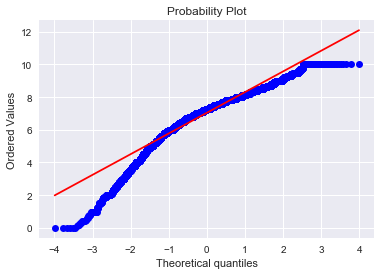

In [114]:
import numpy as np 
import pylab 
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn')
%matplotlib inline
   
stats.probplot(df['score'], dist="norm", plot=pylab)
pylab.show()

In [126]:
df = pd.get_dummies(data=df,columns=['genre'],drop_first=True)
df.columns

Index(['reviewid', 'artist', 'title', 'score', 'year', 'best_new_music',
       'genre_experimental', 'genre_folk/country', 'genre_global',
       'genre_jazz', 'genre_metal', 'genre_pop/r&b', 'genre_rap',
       'genre_rock'],
      dtype='object')

In [133]:
from sklearn import linear_model
model = linear_model.LinearRegression()
x = df[['year','genre_experimental', 'genre_folk/country', 'genre_global',
       'genre_jazz', 'genre_metal', 'genre_pop/r&b', 'genre_rap',
       'genre_rock']]
y = df['score']
model.fit(x,y)
print(model.score(x,y))
model.coef_

0.024610079205914293


array([-0.02213021,  0.40346056,  0.25700698,  0.47878201,  0.37512389,
        0.02800058, -0.00941116,  0.01115051,  0.02520286])

In [49]:
def score_artist(artists_list):
    cum_score = 0
    for artist in artists_list:
        cum_score += df[df['artist']==artist]['score'].mean()
    return cum_score/len(artists_list)

my_artist = ['david bowie','prince','led zeppelin']
sage_artist = ['ariana grande','sza','justin bieber']
print(score_artist(my_artist),score_artist(sage_artist))

7.95787037037037 6.455555555555556
